In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/catvsnoncat/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/catvsnoncat/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
        
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
#loading the data sets
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

In [4]:
#understand the size of data
print(train_x_orig.shape)
print(train_y.shape)
print(test_x_orig.shape)
print(test_y.shape)
print(classes.shape)

(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)
(2,)


y =  0 .Its a non-cat


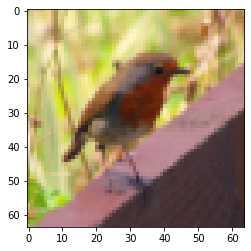

In [5]:
#example of an image
index =10 
plt.imshow(train_x_orig[index])
print("y =  "+ str(train_y[0,index])+ " .Its a "+classes[train_y[0,index]].decode("utf-8"))

In [6]:
# Reshape the training and test examples 
# The "-1" makes reshape flatten the remaining dimensions
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T  
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print (train_x.shape)
print (test_x.shape)

#image was of size 64*64 pixels with 3 layers RGB.
#now we have arranged them in a single array of size 64*64*3

(12288, 209)
(12288, 50)


In [7]:
#initializing parameters Weigth and bais for 2L neural network
def initialize_parameters(n_x, n_h, n_y):
    
    np.random.seed(1)

    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters  

In [38]:
#initializing parameters W and b for deep neural network 
def initialize_parameters_deep(layer_dims):

    np.random.seed(3)
    parameters = {} #python dictionary to hold the parameters
    L = len(layer_dims) #contains the size or len or dimension of each layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])/ np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))

    return parameters     

In [9]:
#activation functions

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)

    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache       


In [10]:
def linear_forward(A,W,b):

    '''
    A-activations from previous layer or inputs
    W-weights matix ,np array with size (current_layer,previous_layer)
    b-bias vector ,  np array with size (current_layer,1)
    '''

    Z = np.dot(W,A)+b

    cache = (A,W,b) #values are required again during computing backpropagation

    return Z,cache 


In [11]:
def linear_activation_forward(A_prev, W, b, activation):

    '''
    activation - specifies the type of activation required Relu or sigmoid
    '''

    if activation == "sigmoid" :
        Z , linear_cache = linear_forward(A_prev,W,b)
        A , activation_cache = sigmoid(Z)

    elif activation == "relu" :
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache) #for effective backpropagation

    #A - activation for current layer
    return A,cache    

In [30]:
#propagate forward
def L_model_forward(X, parameters):
    #X is the input and parameters are the w,b

    caches = []
    A = X
    L = len(parameters) // 2  #number of layers in Nueral Network . W and b is present in parameters

    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],"relu")
        caches.append(cache)
    
    #sigmoid is prefered as the activation function in the last layer of the nueral net
    AL, cache = linear_activation_forward(A,parameters["W"+str(L)],parameters["b"+str(L)],"sigmoid")
    caches.append(cache)

    assert(AL.shape == (1,X.shape[1]))

    return AL, caches

In [13]:
def compute_cost(AL, Y):

    '''
    AL -probability vector corresponding to label predictions, shape (1, number of examples)
    Y - true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    '''
    m = Y.shape[1]
    cost = -1/m*np.sum(np.multiply(np.log(AL),Y) +  np.multiply(np.log(1-AL), (1-Y)))

    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).

    return cost


In [14]:
def linear_backward(dZ, cache):
    '''
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
    '''
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m*np.dot(dZ, A_prev.T)
    db = 1./m*np.sum(dZ, axis = 1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [15]:
# backward for activation functions to calc derivatives

def relu_backward(dA,cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.

    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def sigmoid_backward(dA,cache):

    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


In [16]:
def linear_activation_backward(dA, cache, activation):
    '''
    dA -- post-activation gradient for current layer l 
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    '''

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)

        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)

    
    return dA_prev, dW, db


In [17]:
#back propagation

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache,"sigmoid")

    #for the remaining layers activation is relu
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache,"relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [18]:
#to update parameters while gradient descent

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters    

In [19]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))

    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
            
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p        

In [20]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7  #size of hidden layer
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [21]:
#creating a 2 layerd model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims

    parameters = initialize_parameters(n_x,n_h,n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    for i in range(0, num_iterations):
        A1, cache1 = linear_activation_forward(X,W1,b1,"relu")
        A2, cache2 = linear_activation_forward(A1,W2,b2,"sigmoid")

        cost = compute_cost(A2,Y)

        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        dA1, dW2, db2 = linear_activation_backward(dA2,cache2,"sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1,cache1,"relu")

        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2

        parameters = update_parameters(parameters,grads,learning_rate)

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters


Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.47549013139433255
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.400797753620389
Cost after iteration 900: 0.35807050113237987
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.2749137728213019
Cost after iteration 1300: 0.24681768210614818
Cost after iteration 1400: 0.19850735037466088
Cost after iteration 1500: 0.1744831811255665
Cost after iteration 1600: 0.17080762978096473
Cost after iteration 1700: 0.11306524562164719
Cost after iteration 1800: 0.09629426845937154
Cost after iteration 1900: 0.08342617959726861
Cost after iteration 2000: 0.07439078704319078
Cost after iteration 2100: 0.066307481

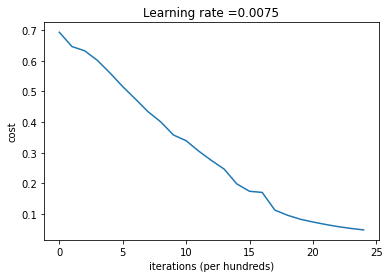

In [22]:
#training the 2 layerd model
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [23]:
#verifying the 2 layerde model
predictions_train = predict(train_x, train_y, parameters)
print(predictions_train)

Accuracy: 0.9999999999999998
[[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
  0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
  0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0.
  1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
  0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [24]:
#testing the two layerd model
predictions_test = predict(test_x, test_y, parameters)
print(predictions_test)

Accuracy: 0.72
[[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.
  1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.
  1. 0.]]


In [25]:
#constants defining the 4 layer model
layers_dims = [12288, 20, 7, 5, 1] 

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []  

    parameters = initialize_parameters_deep(layers_dims)


    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X,parameters)
        
        cost = compute_cost(AL,Y)

        grads = L_model_backward(AL,Y,caches)

        parameters = update_parameters(parameters,grads,learning_rate)

        #print every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters


Cost after iteration 0: 0.715732
Cost after iteration 100: 0.674738
Cost after iteration 200: 0.660337
Cost after iteration 300: 0.646289
Cost after iteration 400: 0.629813
Cost after iteration 500: 0.606006
Cost after iteration 600: 0.569004
Cost after iteration 700: 0.519797
Cost after iteration 800: 0.464157
Cost after iteration 900: 0.408420
Cost after iteration 1000: 0.373155
Cost after iteration 1100: 0.305724
Cost after iteration 1200: 0.268102
Cost after iteration 1300: 0.238725
Cost after iteration 1400: 0.206323
Cost after iteration 1500: 0.179439
Cost after iteration 1600: 0.157987
Cost after iteration 1700: 0.142404
Cost after iteration 1800: 0.128652
Cost after iteration 1900: 0.112443
Cost after iteration 2000: 0.085056
Cost after iteration 2100: 0.057584
Cost after iteration 2200: 0.044568
Cost after iteration 2300: 0.038083
Cost after iteration 2400: 0.034411


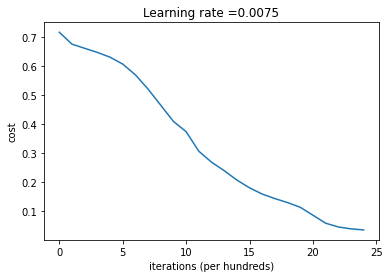

In [41]:
#training the deep layered model
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [61]:
#verifying the trained model
pred_train = predict(train_x, train_y, parameters)
print(pred_train)

Accuracy: 0.9952153110047844
[[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
  0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
  0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0.
  1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
  0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [62]:
#testing the deep layer model
pred_test = predict(test_x, test_y, parameters)
print(pred_test)

Accuracy: 0.78
[[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1.
  1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1.
  0. 0.]]


In [63]:
#Testing with my example 
def predict_example(imgname):

    fname = "images/" + imgname
    img = Image.open(fname)


    img = img.resize((64, 64), Image.ANTIALIAS)
    img_data = np.asarray(img)
    my_image = img_data.reshape(64*64*3,1)
    my_image = my_image/255.


    my_label_y = [1] 
    my_predicted_image = predict(my_image, my_label_y, parameters) 

    plt.imshow(img)
    print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze      (my_predicted_image)),].decode("utf-8") +  "\" picture.")


Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


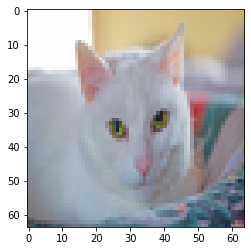

In [64]:
predict_example("my_image2.jpg")